In [1]:
import os
import tensorflow as tf
import numpy as np
import math
from random import sample, shuffle
from PIL import Image
import matplotlib.pyplot as plt
from src.DataGenerator import DataGenerator

In [74]:
data_gen = DataGenerator(
    directory='data/Spotify/pngs/', 
    image_size=(128,512), 
    batch_size=128,
    shuffle=True,
    sample_size=10000, 
    train_test_split=True, 
    test_size=0.05)

Found 9500 files for Training set
Found 500 files for Test set


In [75]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Reshape, Conv2DTranspose, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

img_width = 512
img_height = 128
kernel_size = (5,5)
strides = (2,2)


class Autoencoder(tf.keras.Model):
    
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Sequential([
            Conv2D(input_shape=(img_height, img_width, 1), filters=32, kernel_size=kernel_size, padding="same", strides=strides, activation='relu'),
            BatchNormalization(axis=-1),
            Conv2D(filters=64, kernel_size=kernel_size, padding="same", strides=strides, activation='relu'),
            BatchNormalization(axis=-1),
            Conv2D(filters=128, kernel_size=kernel_size, padding="same", strides=strides, activation='relu'),
            BatchNormalization(axis=-1),
            Conv2D(filters=256, kernel_size=kernel_size, padding="same",strides=strides, activation='relu'),
            BatchNormalization(axis=-1),
            Flatten(),
            Dense(units=latent_dim,)
        ])
        self.decoder = Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            Dense(units=65536, activation='relu'),
            BatchNormalization(axis=-1),
            Reshape(target_shape=(8,32,256)),
            Conv2DTranspose(filters=256, kernel_size=kernel_size, strides=strides, padding="same", activation="relu"),
            BatchNormalization(axis=-1),
            Conv2DTranspose(filters=128, kernel_size=kernel_size, strides=strides, padding="same", activation="relu"),
            BatchNormalization(axis=-1),
            Conv2DTranspose(filters=64, kernel_size=kernel_size,  strides=strides, padding="same", activation="relu"),
            BatchNormalization(axis=-1),
            Conv2DTranspose(filters=32, kernel_size=kernel_size,  strides=strides, padding="same", activation="relu"),
            BatchNormalization(axis=-1),
            Conv2DTranspose(filters=1, kernel_size=kernel_size, padding="same", activation='sigmoid'),
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
autoencoder = Autoencoder(256)

opt = Adam(learning_rate=1e-3)

autoencoder.compile(optimizer=opt, loss=tf.keras.losses.mse)

In [ ]:
hist = autoencoder.fit(data_gen.train,
                       batch_size=data_gen.batch_size,
                       epochs=10,
                       validation_data=data_gen.test)

Epoch 1/10
215/296 [====================>.........] - ETA: 3:28 - loss: 0.0112

In [63]:
prediction_gen = DataGenerator(
    directory='data/Spotify/pngs/', 
    image_size=(128,512), 
    batch_size=1,
    shuffle=False,)

Found 11052 files for Generator set


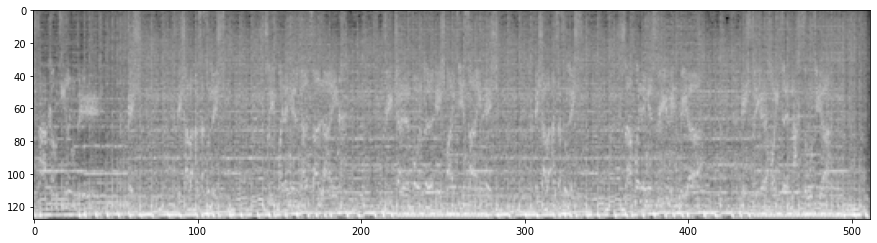

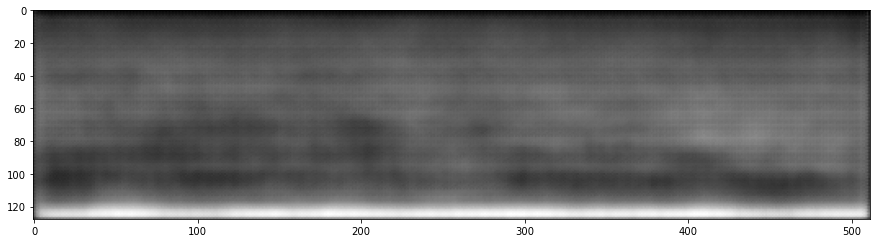

In [73]:
test_img = prediction_gen.take(1234)[0]

prediction = autoencoder(test_img)

plt.figure(figsize=(15,5))
plt.imshow(test_img[0], cmap='gray')
plt.show()
plt.figure(figsize=(15,5))
plt.imshow(np.array(prediction[0]*255),  cmap='gray')

In [404]:
autoencoder.save('data/autoencoder1')

INFO:tensorflow:Assets written to: data/autoencoder1/assets


INFO:tensorflow:Assets written to: data/autoencoder1/assets
